In [6]:
!pip install wget


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=890279e2230a1bc7f1b8abfa38449e7c2c3c35026b2ad84b168d8cd422cf042b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


Get data


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!mkdir /content/drive/MyDrive/sleep_data

mkdir: cannot create directory ‘/content/drive/MyDrive/sleep_data’: File exists


In [ ]:
!mkdir sleep_data

In [9]:
!cp -r /content/drive/MyDrive/sleep_data/data /content/sleep_data

In [ ]:
from cProfile import label
import pickle
import pandas as pd
import wget
import h5py
import json
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import signal




def gen_sleep_data(no_spect=False,test=False):


    print('processing sleep data')

    def create_data(label_size, raw_data):
        raw_data_size = raw_data.size

        # divide number of samples with label size to see how many samples per label
        chunk_size = int(raw_data_size / label_size)

        # evenly distribute labels over signal
        chunked_data = []
        for i in range(0, raw_data_size, chunk_size):
            chunk = raw_data[i:i+chunk_size]
            if no_spect:
                chunked_data.append(chunk)
            else:
                f, t, Zxx = signal.stft(chunk)
                # plt.pcolormesh(t, f, np.abs(Zxx), vmin=0,
                #                vmax=0.2, shading='gouraud')
                # plt.title(
                #     'PSG Spectrogram, Session 1, Epoch 1, 7500 Time-steps')
                # plt.show()
                spectrogram = np.abs(Zxx)
                chunked_data.append(spectrogram)
        return chunked_data

    sleep_sessions = dict()

    print('transforming data...')
    for ndx, filename in enumerate(os.listdir('sleep_data/data')):
        if ndx < len(list(os.listdir('sleep_data/data'))) :
            if filename.endswith(".h5"):
                print(f'processing session {ndx+1}')
                filename = 'sleep_data/data/' + filename
                f = h5py.File(filename, "r")
                session = f'session {ndx+1}'
                labels = f['hypnogram'][()]
                sleep_sessions[session] = dict()
                sleep_sessions[session]['labels'] = labels

                label_size = labels.size
                eegs = f['signals']['eeg']
                emgs = f['signals']['emg']
                eogs = f['signals']['eog']

                for eeg in eegs.keys():
                    eeg_name = eeg
                    eeg_data = eegs[eeg][()]
                    data = create_data(label_size, eeg_data)
                    sleep_sessions[session][eeg_name] = data

                for emg in emgs.keys():
                    emg_name = emg
                    emg_data = emgs[emg][()]
                    data = create_data(label_size, emg_data)
                    sleep_sessions[session][emg_name] = data

                for eog in eogs.keys():
                    eog_name = eog
                    eog_data = eogs[eog][()]
                    data = create_data(label_size, eog_data)
                    sleep_sessions[session][eog_name] = data

    print('saving data...')

    if no_spect:

        with open(f'sleep_sessions_no_spect.pkl', 'wb') as f:
            pickle.dump(sleep_sessions, f)

        print(f'data saved as sleep_sessions_no_spect.pkl')

    else:

        with open(f'sleep_sessions.pkl', 'wb') as f:
            pickle.dump(sleep_sessions, f)

        print(f'data saved as sleep_sessions.pkl')
    if test==False:

      np.save('sleep_x.npy', data)
      np.save('sleep_y.npy', labels)

    return sleep_sessions


# if __name__ == "__main__":


data=gen_sleep_data(no_spect=False,test=False)


processing sleep data
transforming data...
processing session 1
processing session 2
processing session 3
processing session 4
processing session 5
saving data...
data saved as sleep_sessions.pkl


In [ ]:
!pip install pyedflib
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.6 MB/s eta 0:00:00


In [ ]:
import os

import pyedflib
import h5py
import pytz
import datetime as dt
import struct

psg_properties = {'digital_max': [32767],
                      'digital_min': [-32767],
                      'dimension': ['uV'],
                      'physical_min': [-800.0],
                      'physical_max': [800.0],
                      'prefilter': [''],
                      'sample_rate': [250],
                      "transducer": [""]}


def convert_h5_to_edf(h5_path, output_file="psg.edf",psg_properties = psg_properties):
    h5 = h5py.File(h5_path, "r")


    # Check that all ?
    subfolders = ['signals/eeg', 'signals/emg', 'signals/eog']
    psg_labels = []
    for subfolder in subfolders:
        psg_labels.extend([f"{subfolder}/{x}" for x in list(h5[subfolder].keys())])

    try:
        start_time = pytz.timezone('UTC').localize(
            dt.datetime.utcfromtimestamp(h5.attrs["start_time"])
        )
    except KeyError:
        start_time = pytz.timezone('UTC').localize(
            dt.datetime.utcfromtimestamp(0)
        )

    number_of_data_records = int(len(h5[psg_labels[0]]) / 250)
    duration = 1
    header = (
        "0".ljust(8)
        + "".ljust(80)
        + "".ljust(80)
        + start_time.strftime("%d.%m.%y%H.%M.%S")
        + str((len(psg_labels) + 1) * 256).ljust(8)
        + "".ljust(44)
        + str(number_of_data_records).ljust(8)
        + str(duration).ljust(8)
        + str(len(psg_labels)).ljust(4)
    )




    subheaders = (
            "".join([str(x.split('/')[-1]).ljust(16) for x in psg_labels])
            + "".join([str(x).ljust(80) for x in psg_properties['transducer'] * len(psg_labels)])
            + "".join([str(x).ljust(8) for x in psg_properties['dimension'] * len(psg_labels)])
            + "".join([str(x).ljust(8) for x in psg_properties['physical_min'] * len(psg_labels)])
            + "".join([str(x).ljust(8) for x in psg_properties['physical_max'] * len(psg_labels)])
            + "".join([str(x).ljust(8) for x in psg_properties['digital_min'] * len(psg_labels)])
            + "".join([str(x).ljust(8) for x in psg_properties['digital_max'] * len(psg_labels)])
            + "".join([str(x).ljust(80) for x in psg_properties['prefilter'] * len(psg_labels)])
            + "".join([str(x).ljust(8) for x in psg_properties['sample_rate'] * len(psg_labels)])
            + "".ljust(32) * len(psg_labels)
    )
    edf_path = output_file

    with open(edf_path, "wb") as f:
        f.write(bytes(header, "UTF-8"))
        f.write(bytes(subheaders, "UTF-8"))

        def transform(x, min, max):
            if max < min:
                min, max = max, min
            x = x.clip(min, max)
            return (((x - min) / (max - min)) * (2 ** 16 - 1) - (2 ** 15)).astype(int)

        data_transformed = []
        for i, data_path in enumerate(psg_labels):
            data_transformed += [transform(h5[data_path][:], psg_properties['physical_min'][0], psg_properties['physical_max'][0])]

        for i in range(number_of_data_records):
            data = []
            for k, signal_transformed in enumerate(data_transformed):
                data += list(signal_transformed[i * int(psg_properties['sample_rate'][0]): int(psg_properties['sample_rate'][0] * (i + 1))])
            data_to_write = struct.pack("h" * len(data), *data)
            f.write(data_to_write)

    return edf_path


In [ ]:
convert_h5_to_edf('/content/sleep_data/data/0.h5')



'psg.edf'

In [ ]:
import mne

raw =mne.io.read_raw_edf('psg.edf')

Extracting EDF parameters from /content/psg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


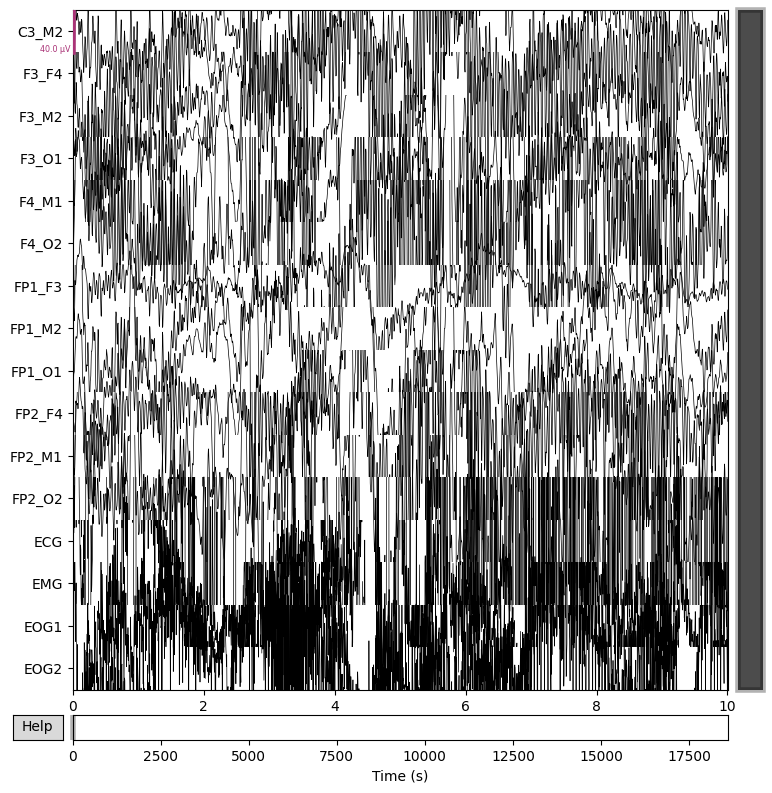

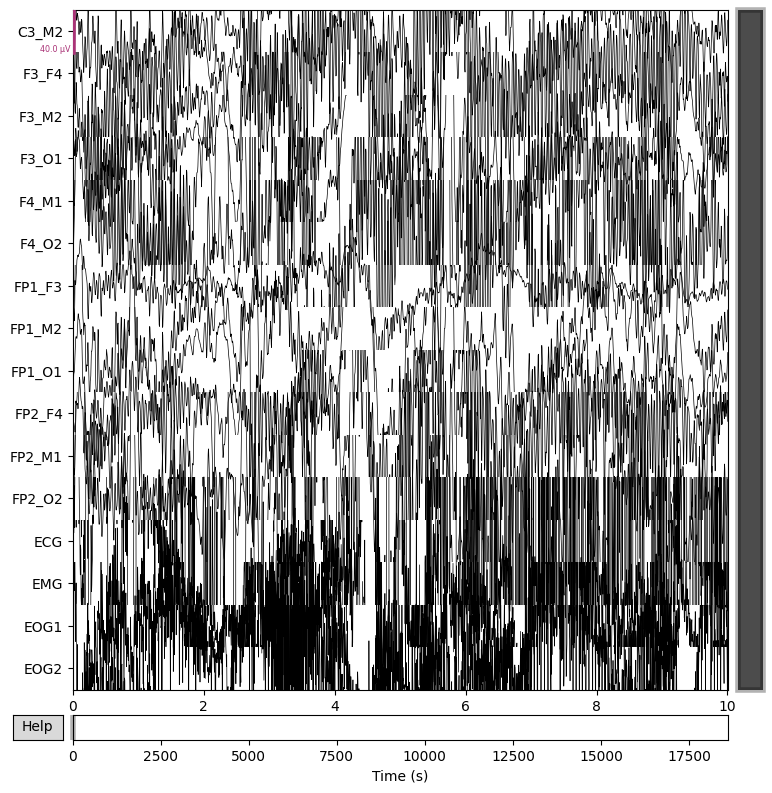

In [ ]:
mne.viz.plot_raw(raw)


[Loading data...]
xshape:  (4681, 16, 129, 60)
yshape:  (4681, 5)


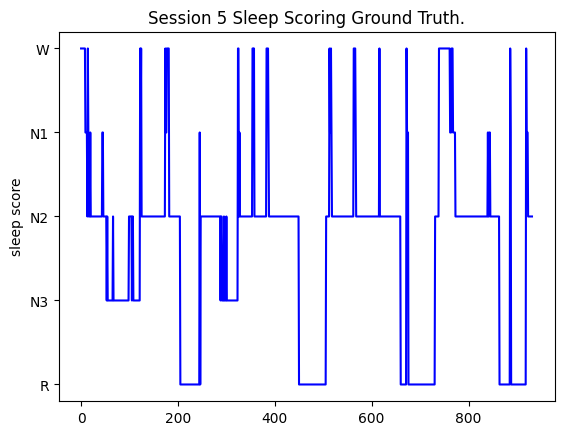

In [ ]:
"""
Processes sleep data in the format of standard sleep study or AASM standard label set.
"""

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow import keras
from scipy import signal

STFT = True


class AASM:

    def __init__(self, create_training_data=True, time_series=True):
        self.time_series = time_series
        self.create_training_data = create_training_data
        self.domain = 'AASM'
        self.step_size = 2
        self.seq = 2
        self.load_data()

    def load_model(self):
        model = f'../models/{self.domain}.model'
        print('Loading model...')
        self.model = keras.models.load_model(model)
        print('Done.')

    def load_data(self):
        print('\n[Loading data...]')
        try:

            if STFT:
                with open('sleep_sessions.pkl', 'rb') as f:
                    self.sessions = pickle.load(f)
            else:
                with open('sleep_sessions_no_spect.pkl', 'rb') as f:
                    self.sessions = pickle.load(f)
        except BaseException as e:
            print(e)
            self.sessions = []
        if self.create_training_data == False:
            return
        self.x = []
        self.y = []
        if not self.sessions == []:
            for session in self.sessions.keys():
                data = []
                session_dict = self.sessions[session]
                for data_key in session_dict.keys():
                    if data_key == 'labels':
                        labels = session_dict[data_key]
                        for label in labels:
                            onehot = [0, 0, 0, 0, 0]
                            onehot[label] = 1
                            self.y.append(onehot)
                    else:
                        data.append(session_dict[data_key])

                for i in range(len(labels)):
                    single_sample_data = []
                    for signal_data in data:
                        single_sample_data.append(signal_data[i])
                    self.x.append(single_sample_data)

            print('xshape: ', np.array(self.x).shape)
            print('yshape: ', np.array(self.y).shape)

        if self.time_series:
            self.create_time_series()
        else:
            domain = self.domain
            if not STFT:
                domain = 'AASM_NO_SPECT'
            x_cache_str = f'type{domain}_SEQ{16}_x.npy'
            y_cache_str = f'type{domain}_SEQ{16}_y.npy'
            np.save(x_cache_str, self.x)
            np.save(y_cache_str, self.y)

    def create_time_series(self):
        print('\n[Creating Time-Series Data...]\n')
        seq = self.seq
        self.x_time_series = []
        self.y_time_series = []
        for i in range(0, len(self.x) - self.seq, self.step_size):
            data = self.x[i: i+self.seq]
            label = self.y[i+self.seq]
            concat_spects = []  # will be of size self.seq * 16
            for time_step in data:
                for spect in time_step:
                    concat_spects.append(spect)
            self.x_time_series.append(concat_spects)
            self.y_time_series.append(label)

        print('Converting to np array...')
        self.x_time_series = np.array(self.x_time_series, dtype=np.float32)
        self.y_time_series = np.array(self.y_time_series)

        # SAVE AS NPY CACHE FOR MAIN SLEEPNET
        domain = self.domain
        x_cache_str = f'type{domain}_SEQ{seq}_x.npy'
        y_cache_str = f'type{domain}_SEQ{seq}_y.npy'

        print('\n[Saving X and Y as cache...]')
        if not os.path.exists('../cache/'):
            os.mkdir('../cache/')
        np.save('../cache/'+x_cache_str, self.x_time_series)
        np.save('../cache/'+y_cache_str, self.y_time_series)

    def visualize_data(self, session_num=5):  # visualize testing session #13
        y = self.sessions[list(self.sessions.keys())[session_num]]['labels']
        plt.plot(y, color='b')
        session_num += 1
        plt.title(f'Session {session_num} Sleep Scoring Ground Truth.')
        ax = plt.gca()
        ax.invert_yaxis()
        plt.ylabel(f'sleep score')
        plt.yticks([0, 1, 2, 3, 4], ['W', 'N1', 'N2', 'N3', 'R'])
        plt.show()

    def predict_session(self, session_num):
        self.load_model()
        seq = self.seq
        step_size = self.step_size
        xtest_time_series = []
        ytest_time_series = []

        session = []  # will hold raw session data at session_num
        session_x = []  # will hold transformed session data ready for tensor

        # get labels from self.sessions
        labels = self.sessions[list(self.sessions.keys())[
            session_num]]['labels']

        # get session data from self.sessions
        for data_key in self.sessions[list(self.sessions.keys())[
                session_num]].keys():
            if not data_key == 'labels':
                session.append(self.sessions[list(self.sessions.keys())[
                    session_num]][data_key])

        # transform to be in correct shape for training
        for i in range(len(labels)):
            single_sample_data = []
            for signal_data in session:
                single_sample_data.append(signal_data[i])
            session_x.append(single_sample_data)

        # create ground truth hypnogram time series
        # for i in range(0, len(labels) - self.seq, step_size):
        #     data = session_x[i: i+self.seq]
        #     onehot = [0, 0, 0, 0, 0]
        #     label = labels[i+self.seq]
        #     onehot[label] = 1
        #     concat_spects = []  # will be of size self.seq * 16
        #     for time_step in data:
        #         for spect in time_step:
        #             concat_spects.append(spect)
        #     xtest_time_series.append(concat_spects)
        #     ytest_time_series.append(onehot)

        self.xtest_time_series = np.array(session_x)
        self.ytest_time_series = np.array(labels)

        self.y_pred = []
        size = len(self.ytest_time_series)
        for itr, sample in enumerate(self.xtest_time_series):
            pred = self.model.predict(np.expand_dims(sample, 0))
            self.y_pred.append(np.argmax(pred))
            progress = (itr/size)*100
            if itr % 100 == 0:
                print(f'{progress}%')
            if progress >= 50:
                break  # stop at 50% of sleep session
        print('100.0%')

        fig = plt.figure()
        gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

        ax0 = plt.subplot(gs[0])
        ax0.invert_yaxis()
        ytest_by_class = []
        for x in self.ytest_time_series:
            ytest_by_class.append(np.argmax(x))
        line0, = ax0.plot(ytest_by_class, color='b')
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.ylabel(f'Ground Truth')
        plt.yticks([0, 1, 2, 3, 4], ['W', 'N1', 'N2', 'N3', 'R'])
        plt.title(
            f'Session {session_num+1} Sleep Scoring Predictions and Ground Truth.')

        ax1 = plt.subplot(gs[1])
        line1, = ax1.plot(self.y_pred, color='r')
        ax1.invert_yaxis()
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.ylabel(f'SleepNet Prediction')
        plt.yticks([0, 1, 2, 3, 4], ['W', 'N1', 'N2', 'N3', 'R'])

        plt.subplots_adjust(hspace=0.1)

        plt.show()


if __name__ == "__main__":
    aasm = AASM(
        create_training_data=True,
        # create_training_data=False,
        time_series=False
    )
    aasm.visualize_data(4)
    # aasm.predict_session(10)

FOR APPROXIMATELY 40 YEARS THE ONLY WIDELY ACCEPTED STANDARD FOR DESCRIBING THE HUMAN SLEEP PROCESS WAS THE MANUAL OF SLEEP CLASSIFICATION by Rechtschaffen and Kales.1 On the basis of these scoring rules, sleep recordings are divided into 7 discrete stages (wake, stage 1, stage 2, stage 3, stage 4, stage REM, and movement time)    One of the major changes is a change in terminology: in the AASM classification, sleep stages S1 to S4 are referred to as N1, N2, and N3, with N3 reflecting slow wave sleep (SWS, R&K stages S3 + S4); stage REM is referred to as stage R.

xshape: 16 yshape: 5

[Training CNNLSTM Model...]


Epoch 1/15
110/110 [==============================] - 169s 1s/step - loss: 0.9013 - accuracy: 0.6516
Epoch 2/15
110/110 [==============================] - 156s 1s/step - loss: 0.6279 - accuracy: 0.7803
Epoch 3/15
110/110 [==============================] - 160s 1s/step - loss: 0.5487 - accuracy: 0.8142
Epoch 4/15
110/110 [==============================] - 158s 1s/step - loss: 0.5020 - accuracy: 0.8288
Epoch 5/15
110/110 [==============================] - 155s 1s/step - loss: 0.4242 - accuracy: 0.8575
Epoch 6/15
110/110 [==============================] - 151s 1s/step - loss: 0.4248 - accuracy: 0.8484
Epoch 7/15
110/110 [==============================] - 153s 1s/step - loss: 0.3899 - accuracy: 0.8661
Epoch 8/15
110/110 [==============================] - 156s 1s/step - loss: 0.3776 - accuracy: 0.8647
Epoch 9/15
110/110 [==============================] - 152s 1s/step - loss: 0.3783 - accuracy: 0.8732
Epoch 10/15
110/110 [==================

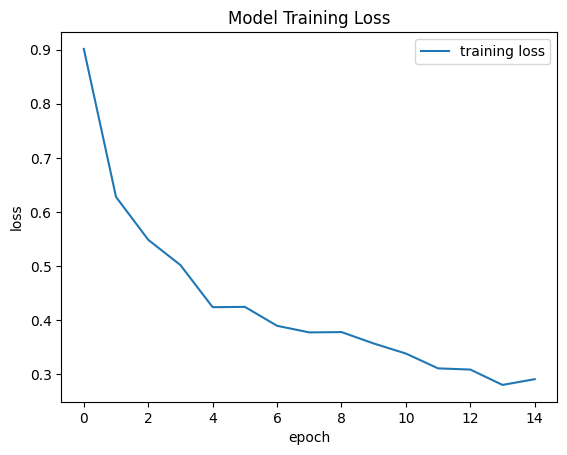

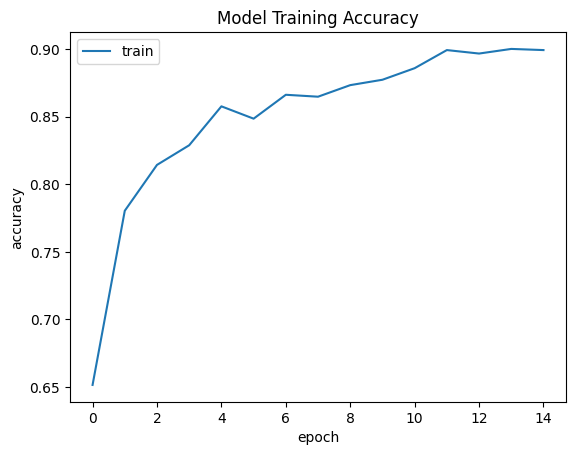

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 256)           291203    
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 16, 128)           164352    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:


import json
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
from sklearn import metrics
import ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import \
    LSTM, Dense, Activation, Dropout, \
    Bidirectional, TimeDistributed, \
    Conv2D, MaxPooling2D, Flatten, Conv1D, MaxPooling1D, \
    Resizing, Normalization, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


class SleepNet:
    """
    Creates and trains sleep / wake prediction models and plots results.
    Model is saved to models/ as a Tensorflow / Keras .model file.
    """

    def __init__(self, domain='UrbanPoorIndia', model_arch='LSTM', seq=10):
        self.seq = seq
        self.type = domain
        self.model_arch = model_arch
        if STFT:
            domain += '_stft'
        x_cache_str = f'/content/typeAASM_SEQ16_x.npy'
        y_cache_str = f'/content/typeAASM_SEQ16_y.npy'
        self.x = []
        self.y = []
        # if x_cache_str in os.listdir('cache'):
          # print('\n[Found cached processed data! Loading...]')
        self.x = np.load(x_cache_str)
        self.y = np.load(y_cache_str)
        # else:
        #     print(f'\n[No X and Y cache found for type: {domain}, seq: {seq}]')

    def create_model(self, units=None):
        """
        Create LSTM model with relu activation and MSE loss.
        """
        model_arch = self.model_arch
        model = Sequential()
        if self.type == 'UrbanPoorIndia' and not self.model_arch == 'CNNLSTM':
            xshape = self.x.shape
            yshape = 1
            print(f'xshape: {xshape}', f'yshape: {yshape}')
            if model_arch == 'LSTM':
                self.early_stop_callback = tf.keras.callbacks.EarlyStopping(
                    monitor='loss', patience=3, restore_best_weights=True)
                model.add(LSTM(units, input_shape=(xshape[1], xshape[2])))
                model.add(Activation('relu'))
                model.add(Dense(yshape))
                model.add(Activation('relu'))
                model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError(
                ), metrics='accuracy')
                return model
            elif model_arch == 'XGBoost':  # XGBoost goes here...
                model = xgb.XGBRegressor(
                    max_depth=7,
                    learning_rate=0.1
                )
                return model
        else:
            xshape = self.x.shape[1]
            yshape = 1 if self.type == 'UrbanPoorIndia' else self.y.shape[1]
            print(f'xshape: {xshape}', f'yshape: {yshape}')
            if model_arch == 'LSTM':
                self.early_stop_callback = tf.keras.callbacks.EarlyStopping(
                    monitor='loss', patience=3, restore_best_weights=True)
                # model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=(xshape,self.seq)))
                # model.add(Bidirectional(LSTM(units)))
                # model.add(Activation('relu'))
                # model.add(Dropout(0.2))
                model.add(LSTM(units, input_shape=(xshape, self.seq)))
                # model.add(Activation('sigmoid'))
                model.add(Dense(yshape, activation='sigmoid')) if yshape == 1 else model.add(
                    Dense(yshape, activation='softmax'))
                model.compile(loss='categorical_crossentropy',
                              optimizer='rmsprop', metrics='accuracy')
                return model

            elif self.model_arch == 'CNN':
                self.early_stop_callback = tf.keras.callbacks.EarlyStopping(
                    monitor='loss', patience=3, restore_best_weights=True)
                N = 256
                OUTPUT = 5 if 'AASM' in self.type else 1
                conv_model = Sequential()
                conv_model.add(Resizing(32, 32))
                conv_model.add(Normalization()),
                conv_model.add(Conv2D(
                    32, (5, 5), strides=(1, 1), padding="same", activation="relu"))
                conv_model.add(BatchNormalization())
                conv_model.add(MaxPooling2D(pool_size=(2, 2)))

                conv_model.add(Conv2D(
                    64, (3, 3), strides=(2, 2), padding="same", activation="relu"))
                conv_model.add(BatchNormalization())
                conv_model.add(MaxPooling2D(
                    pool_size=(2, 2), padding='same'))

                conv_model.add(Conv2D(
                    128, (3, 3), strides=(2, 2), padding="same", activation="relu"))
                conv_model.add(BatchNormalization())

                conv_model.add(Flatten())
                conv_model.add(Dense(N, activation='relu'))
                model.add(TimeDistributed(conv_model, input_shape=(
                    self.x.shape[1], self.x.shape[2], self.x.shape[3], 1)))
                model.add(Flatten())
                model.add(Dense(int(N), activation='relu'))
                model.add(Dropout(0.3))
                model.add(Dense(OUTPUT))
                model.add(Activation('softmax')) if OUTPUT == 5 else model.add(
                    Activation('sigmoid'))
                model.compile(loss='categorical_crossentropy' if OUTPUT == 5 else 'binary_crossentropy',
                                   optimizer='adam', metrics='accuracy')
                return model

            elif self.model_arch == 'CNNLSTM':
                self.early_stop_callback = tf.keras.callbacks.EarlyStopping(
                    monitor='loss', patience=3, restore_best_weights=True)
                N = 256
                OUTPUT = 5 if 'AASM' in self.type else 1
                conv_model = Sequential()
                conv_model.add(Resizing(32, 32))
                conv_model.add(Normalization()),
                conv_model.add(Conv2D(
                    32, (5, 5), strides=(1, 1), padding="same", activation="relu"))
                conv_model.add(BatchNormalization())
                conv_model.add(MaxPooling2D(pool_size=(2, 2)))

                conv_model.add(Conv2D(
                    64, (3, 3), strides=(2, 2), padding="same", activation="relu"))
                conv_model.add(BatchNormalization())
                conv_model.add(MaxPooling2D(
                    pool_size=(2, 2), padding='same'))

                conv_model.add(Conv2D(
                    128, (3, 3), strides=(2, 2), padding="same", activation="relu"))
                conv_model.add(BatchNormalization())

                conv_model.add(Flatten())
                conv_model.add(Dense(N, activation='relu'))
                conv_model.add(Dropout(0.3))
                conv_model.add(Dense(N, activation='relu'))
                conv_model.add(Dropout(0.3))
                model.add(TimeDistributed(conv_model, input_shape=(
                    self.x.shape[1], self.x.shape[2], self.x.shape[3], 1)))

                model.add(Bidirectional(LSTM(64, return_sequences=True))),
                # model.add(LSTM(32, return_sequences=True)),
                model.add(Bidirectional(LSTM(64))),
                model.add(Dense(int(N), activation='relu'))
                model.add(Dropout(0.3))
                model.add(Dense(int(N), activation='relu'))
                model.add(Dropout(0.3))
                model.add(Dense(OUTPUT))
                model.add(Activation('softmax')) if OUTPUT == 5 else model.add(
                    Activation('sigmoid'))
                model.compile(loss='categorical_crossentropy' if OUTPUT == 5 else 'binary_crossentropy',
                              optimizer='adam', metrics='accuracy')
                return model

    def train_model(self, model=None, name=None, epochs=None, learning_rate=None, rounds=None, depth=None):
        """
        Train model with optimal parameters.
        """
        print(f'\n[Training {self.model_arch} Model...]\n\n')
        xtrain, xtest, ytrain, ytest = train_test_split(self.x, self.y)
        if self.model_arch == 'LSTM' or 'CNN' in self.model_arch:
            self.hist = model.fit(
                xtrain, ytrain, epochs=epochs, verbose=1, batch_size=32, callbacks=[self.early_stop_callback])
            self.plot_history(self.hist)
            model.summary()
            self.ypreds = model.predict(xtest)
            self.get_accuracy(ytest, self.ypreds)
            self.ytest = ytest
            model.save(f'models/{name}')
        elif self.model_arch == 'XGBoost':
            print('xShape:', np.array(xtrain).shape)
            self.xtrain = xtrain
            self.ytrain = ytrain
            self.ytest = ytest
            xtrain = []
            for x in self.xtrain:
                xtrain.append(x.flatten())
            # model.fit(xtrain, ytrain)
            dtrain = xgb.DMatrix(data=xtrain, label=ytrain)
            params = {
                'max_depth': depth,
                'learning_rate': learning_rate,
                'objective': 'reg:squarederror',
                'eval_metric': 'logloss'
            }
            rounds = rounds
            evals_result = {}

            watchlist = [(dtrain, 'eval')]
            model = xgb.train(params, dtrain, rounds,
                              watchlist, evals_result=evals_result)

            xtest_ = []
            for x in xtest:
                xtest_.append(x.flatten())
            dtest = xgb.DMatrix(data=xtest_)
            self.ypreds = model.predict(dtest)
            accuracy = self.get_accuracy(ytest, self.ypreds)
            self.results = evals_result
            results = self.results
            model.save_model("models/xgboost_sleep_wake_model.json")
            return model, results, accuracy

    def get_accuracy(self, yT, yP):
        if self.type == 'UrbanPoorIndia':
            yP = yP.round()
            accuracy = accuracy_score(yT, yP)
            recall = recall_score(yT, yP, average='micro')
            precision = precision_score(yT, yP, average='micro')
            f1 = f1_score(yT, yP, average='micro')
            print('\n')
            print('recall', recall)
            print('precision', precision)
            print('f1', f1)
        else:
            y_truth = []
            y_pred = []
            for i in range(len(yT)):
                y_truth.append(np.argmax(yT[i]))
                y_pred.append(np.argmax(yP[i]))
            accuracy = accuracy_score(y_truth, y_pred)
            recall = recall_score(y_truth, y_pred, average='micro')
            precision = precision_score(y_truth, y_pred, average='micro')
            f1 = f1_score(y_truth, y_pred, average='micro')
            print('\n')
            print('recall', recall)
            print('precision', precision)
            print('f1', f1)
        print(f'\nAccuracy: {accuracy}\n')
        return accuracy

    def train_model_sweep(self):
        """
        Test different model parameters to know how to fine-tune accuracy.
        """
        print(f'\n[Starting {self.model_arch} Parameter Sweep...]\n\n')

        if self.model_arch == 'LSTM':
            units_ = [64, 128, 256, 512]
            # units_ = [8, 32, 64]
            epochs_ = [2, 5, 10, 15]
            # epochs_ = [2, 5, 10]
            xtrain, xtest, ytrain, ytest = train_test_split(self.x, self.y)

            sweep_dict = {}
            for i in range(len(units_)):
                for w in range(len(epochs_)):
                    units, epochs = units_[i], epochs_[w]
                    print(
                        f'\n[Training with {units} units and {epochs} epoch(s)]\n')
                    model = self.create_model(units)
                    self.hist = model.fit(
                        xtrain, ytrain, epochs=epochs, verbose=1)
                    self.ypreds = model.predict(xtest)
                    accuracy = accuracy_score(ytest, self.ypreds.round())
                    sweep_dict[str((units, epochs))] = [self.hist, accuracy]

            keys = sweep_dict.keys()
            self.sweep_dict = {}
            for key in keys:
                hist = sweep_dict[key][0].history
                testing_accuracy = sweep_dict[key][1]
                self.sweep_dict[str(key)] = {
                    "loss": hist['loss'], "accuracy": hist['accuracy'], "testing_accuracy": testing_accuracy}
            with open(f'{self.type}_{self.model_arch}_param_sweep.json', 'w') as f:
                json.dump(self.sweep_dict, f)

        elif self.model_arch == 'XGBoost':
            rounds_ = [5, 10, 20]
            learning_rates_ = [0.1, 0.5, 0.7]
            depths_ = [1, 5, 7]
            sweep_dict = {}
            for rounds in rounds_:
                sweep_dict[rounds] = []
                for learning_rate in learning_rates_:
                    for depth in depths_:
                        print(
                            f'\n[Training with {rounds} rounds, {learning_rate} learning rate, and max depth {depth}]\n')
                        model, results, accuracy = self.train_model(
                            learning_rate=learning_rate, rounds=rounds, depth=depth)
                        sweep_dict[rounds].append(
                            [str((learning_rate, depth)), results['eval']['logloss'], accuracy])

            with open(f'{self.type}_{self.model_arch}_param_sweep.json', 'w') as f:
                json.dump(sweep_dict, f)

    def plot_history(self, history):
        plt.figure()
        plt.plot(history.history['loss'])
        plt.title('Model Training Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['training loss'], loc='upper right')

        plt.figure()
        plt.plot(history.history['accuracy'])
        plt.title('Model Training Accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()



    def get_model_metrics(self, model=None):
        print('\n[Getting model metrics...]\n')
        xtrain, xtest, ytrain, ytest = train_test_split(self.x, self.y)
        if model == None:
            model = keras.models.load_model(f'models/{self.type}.model')
        ypreds = model.predict(xtest).round()
        accuracy = accuracy_score(ytest, ypreds)
        if 'AASM' in self.type:
            f1 = f1_score(ytest, ypreds, average='micro')
            recall = recall_score(ytest, ypreds, average='micro')
            precision = precision_score(ytest, ypreds, average='micro')
        else:
            f1 = f1_score(ytest, ypreds)
        print('\n\n')
        print(recall, precision, f1, accuracy)


if __name__ == "__main__":

    DOMAIN = 0
    MODEL = 3
    SEQ = 16
    # SEQ = 7500
    # SEQ = 4096
    # SEQ = 128
    STFT = False

    domains = ['AASM']
    models = ['LSTM', 'XGBoost', 'CNNLSTM', 'CNN']

    net = domains[DOMAIN]
    arch = models[MODEL]


    sleepnet = SleepNet(net, model_arch=arch, seq=SEQ)
    model = sleepnet.create_model(units=256)
    sleepnet.train_model(model, net+f'_{arch}.model', epochs=15,
                          learning_rate=0.7, rounds=20, depth=10)

    model.save("sleep_score.h5")

In [ ]:
from cProfile import label
import pickle
import pandas as pd
import wget
import h5py
import json
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import signal




def gen_test_case(no_spect=False,test=False):


    print('processing sleep data')

    def create_data(label_size, raw_data):
        raw_data_size = raw_data.size

        # divide number of samples with label size to see how many samples per label
        chunk_size = int(raw_data_size / label_size)

        # evenly distribute labels over signal
        chunked_data = []
        for i in range(0, raw_data_size, chunk_size):
            chunk = raw_data[i:i+chunk_size]
            if no_spect:
                chunked_data.append(chunk)
            else:
                f, t, Zxx = signal.stft(chunk)
                # plt.pcolormesh(t, f, np.abs(Zxx), vmin=0,
                #                vmax=0.2, shading='gouraud')
                # plt.title(
                #     'PSG Spectrogram, Session 1, Epoch 1, 7500 Time-steps')
                # plt.show()
                spectrogram = np.abs(Zxx)
                chunked_data.append(spectrogram)
        return chunked_data

    sleep_sessions = dict()

    print('transforming data...')
    for ndx, filename in enumerate(os.listdir('/content/sleep_data/data')):
        if ndx ==2 :
            if filename.endswith(".h5"):
                print(f'processing session {ndx+1}')
                filename = '/content/sleep_data/data/' + filename
                f = h5py.File(filename, "r")
                session = f'session {ndx+1}'
                labels = f['hypnogram'][()]
                sleep_sessions[session] = dict()
                sleep_sessions[session]['labels'] = labels

                label_size = labels.size
                eegs = f['signals']['eeg']
                emgs = f['signals']['emg']
                eogs = f['signals']['eog']

                for eeg in eegs.keys():
                    eeg_name = eeg
                    eeg_data = eegs[eeg][()]
                    data = create_data(label_size, eeg_data)
                    sleep_sessions[session][eeg_name] = data

                for emg in emgs.keys():
                    emg_name = emg
                    emg_data = emgs[emg][()]
                    data = create_data(label_size, emg_data)
                    sleep_sessions[session][emg_name] = data

                for eog in eogs.keys():
                    eog_name = eog
                    eog_data = eogs[eog][()]
                    data = create_data(label_size, eog_data)
                    sleep_sessions[session][eog_name] = data

    print('saving data...')

    if no_spect:

        with open(f'sleep_sessions_no_spect.pkl', 'wb') as f:
            pickle.dump(sleep_sessions, f)

        print(f'data saved as sleep_sessions_no_spect.pkl')

    else:

        with open(f'sleep_sessions.pkl', 'wb') as f:
            pickle.dump(sleep_sessions, f)

        print(f'data saved as sleep_sessions.pkl')
    if test==False:

      np.save('sleep_x_t.npy', data)
      np.save('sleep_y_t.npy', labels)

    return sleep_sessions


# if __name__ == "__main__":


data=gen_test_case(no_spect=False,test=False)


processing sleep data
transforming data...
processing session 3
saving data...
data saved as sleep_sessions.pkl



[Loading data...]
xshape:  (969, 16, 129, 60)
yshape:  (969, 5)


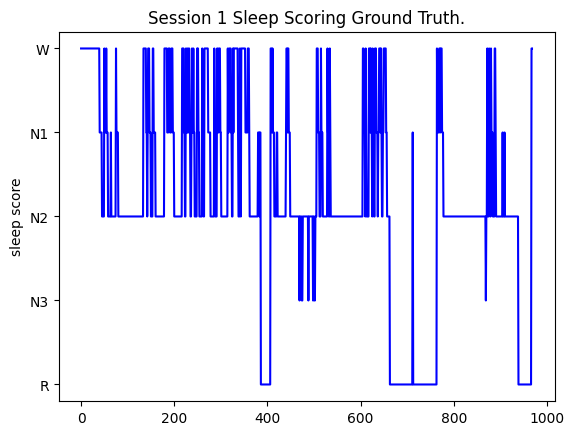

In [ ]:
"""
Processes sleep data in the format of standard sleep study or AASM standard label set.
"""

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow import keras
from scipy import signal

STFT = True


class AASM:

    def __init__(self, create_training_data=True, time_series=True):
        self.time_series = time_series
        self.create_training_data = create_training_data
        self.domain = 'AASM'
        self.step_size = 2
        self.seq = 2
        self.load_data()

    def load_model(self):
        model = f'../models/{self.domain}.model'
        print('Loading model...')
        self.model = keras.models.load_model(model)
        print('Done.')

    def load_data(self):
        print('\n[Loading data...]')
        try:

            if STFT:
                with open('sleep_sessions.pkl', 'rb') as f:
                    self.sessions = pickle.load(f)
            else:
                with open('sleep_sessions_no_spect.pkl', 'rb') as f:
                    self.sessions = pickle.load(f)
        except BaseException as e:
            print(e)
            self.sessions = []
        if self.create_training_data == False:
            return
        self.x = []
        self.y = []
        if not self.sessions == []:
            for session in self.sessions.keys():
                data = []
                session_dict = self.sessions[session]
                for data_key in session_dict.keys():
                    if data_key == 'labels':
                        labels = session_dict[data_key]
                        for label in labels:
                            onehot = [0, 0, 0, 0, 0]
                            onehot[label] = 1
                            self.y.append(onehot)
                    else:
                        data.append(session_dict[data_key])

                for i in range(len(labels)):
                    single_sample_data = []
                    for signal_data in data:
                        single_sample_data.append(signal_data[i])
                    self.x.append(single_sample_data)

            print('xshape: ', np.array(self.x).shape)
            print('yshape: ', np.array(self.y).shape)

        if self.time_series:
            self.create_time_series()
        else:
            domain = self.domain
            if not STFT:
                domain = 'AASM_NO_SPECT'
            x_cache_str = f'type{domain}_SEQ{16}_x.npy'
            y_cache_str = f'type{domain}_SEQ{16}_y.npy'
            np.save(x_cache_str, self.x)
            np.save(y_cache_str, self.y)

    def create_time_series(self):
        print('\n[Creating Time-Series Data...]\n')
        seq = self.seq
        self.x_time_series = []
        self.y_time_series = []
        for i in range(0, len(self.x) - self.seq, self.step_size):
            data = self.x[i: i+self.seq]
            label = self.y[i+self.seq]
            concat_spects = []  # will be of size self.seq * 16
            for time_step in data:
                for spect in time_step:
                    concat_spects.append(spect)
            self.x_time_series.append(concat_spects)
            self.y_time_series.append(label)

        print('Converting to np array...')
        self.x_time_series = np.array(self.x_time_series, dtype=np.float32)
        self.y_time_series = np.array(self.y_time_series)

        # SAVE AS NPY CACHE FOR MAIN SLEEPNET
        domain = self.domain
        x_cache_str = f'type{domain}_SEQ{seq}_x.npy'
        y_cache_str = f'type{domain}_SEQ{seq}_y.npy'

        print('\n[Saving X and Y as cache...]')
        if not os.path.exists('../cache/'):
            os.mkdir('../cache/')
        np.save('../cache/'+x_cache_str, self.x_time_series)
        np.save('../cache/'+y_cache_str, self.y_time_series)

    def visualize_data(self, session_num=5):  # visualize testing session #13
        y = self.sessions[list(self.sessions.keys())[session_num]]['labels']
        plt.plot(y, color='b')
        session_num += 1
        plt.title(f'Session {session_num} Sleep Scoring Ground Truth.')
        ax = plt.gca()
        ax.invert_yaxis()
        plt.ylabel(f'sleep score')
        plt.yticks([0, 1, 2, 3, 4], ['W', 'N1', 'N2', 'N3', 'R'])
        plt.show()

    def predict_session(self, session_num):
        self.load_model()
        seq = self.seq
        step_size = self.step_size
        xtest_time_series = []
        ytest_time_series = []

        session = []  # will hold raw session data at session_num
        session_x = []  # will hold transformed session data ready for tensor

        # get labels from self.sessions
        labels = self.sessions[list(self.sessions.keys())[
            session_num]]['labels']

        # get session data from self.sessions
        for data_key in self.sessions[list(self.sessions.keys())[
                session_num]].keys():
            if not data_key == 'labels':
                session.append(self.sessions[list(self.sessions.keys())[
                    session_num]][data_key])

        # transform to be in correct shape for training
        for i in range(len(labels)):
            single_sample_data = []
            for signal_data in session:
                single_sample_data.append(signal_data[i])
            session_x.append(single_sample_data)

        # create ground truth hypnogram time series
        # for i in range(0, len(labels) - self.seq, step_size):
        #     data = session_x[i: i+self.seq]
        #     onehot = [0, 0, 0, 0, 0]
        #     label = labels[i+self.seq]
        #     onehot[label] = 1
        #     concat_spects = []  # will be of size self.seq * 16
        #     for time_step in data:
        #         for spect in time_step:
        #             concat_spects.append(spect)
        #     xtest_time_series.append(concat_spects)
        #     ytest_time_series.append(onehot)

        self.xtest_time_series = np.array(session_x)
        self.ytest_time_series = np.array(labels)

        self.y_pred = []
        size = len(self.ytest_time_series)
        for itr, sample in enumerate(self.xtest_time_series):
            pred = self.model.predict(np.expand_dims(sample, 0))
            self.y_pred.append(np.argmax(pred))
            progress = (itr/size)*100
            if itr % 100 == 0:
                print(f'{progress}%')
            if progress >= 50:
                break  # stop at 50% of sleep session
        print('100.0%')

        fig = plt.figure()
        gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

        ax0 = plt.subplot(gs[0])
        ax0.invert_yaxis()
        ytest_by_class = []
        for x in self.ytest_time_series:
            ytest_by_class.append(np.argmax(x))
        line0, = ax0.plot(ytest_by_class, color='b')
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.ylabel(f'Ground Truth')
        plt.yticks([0, 1, 2, 3, 4], ['W', 'N1', 'N2', 'N3', 'R'])
        plt.title(
            f'Session {session_num+1} Sleep Scoring Predictions and Ground Truth.')

        ax1 = plt.subplot(gs[1])
        line1, = ax1.plot(self.y_pred, color='r')
        ax1.invert_yaxis()
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.ylabel(f'SleepNet Prediction')
        plt.yticks([0, 1, 2, 3, 4], ['W', 'N1', 'N2', 'N3', 'R'])

        plt.subplots_adjust(hspace=0.1)

        plt.show()


if __name__ == "__main__":
    aasm = AASM(
        create_training_data=True,
        # create_training_data=False,
        time_series=False
    )
    aasm.visualize_data(0)
    # aasm.predict_session(10)

In [ ]:
x_cache_str = f'/content/typeAASM_SEQ16_x.npy'
y_cache_str = f'/content/typeAASM_SEQ16_y.npy'
x = []
y = []
# if x_cache_str in os.listdir('cache'):
  # print('\n[Found cached processed data! Loading...]')
x = np.load(x_cache_str)
y = np.load(y_cache_str)

[0, 1, 2, 3, 4], ['W', 'N1', 'N2', 'N3', 'R']

In [ ]:
yy=model.predict(x).round()

NameError: name 'model' is not defined

In [ ]:
print(yy[1:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
from collections import Counter



mapping = ['W', 'N1', 'N2', 'N3', 'R']
cycle_scores = [10, 20, 30, 40, 30]  # Scores for W, N1, N2, N3, and R respectively (out of 50)

yy_tuples = [tuple(arr) for arr in yy]
counts = Counter(yy_tuples)
total_counts = sum(counts.values())
percentages = []

for tup, count in counts.items():
    percentage = (count / total_counts) * 100
    percentages.append((tup, percentage))

# Calculate the Quality of Sleep Score (out of 50)
quality_score = 0
for tup, percentage in percentages:
    for i, val in enumerate(tup):
        if val == 1.0:
            quality_score += (cycle_scores[i] / 100) * percentage

print(f"Quality of Sleep Score (out of 50): {quality_score:.2f}")

NameError: name 'yy' is not defined

In [ ]:
from collections import Counter

yy =yy
mapping = ['W', 'N1', 'N2', 'N3', 'R']

yy_tuples = [tuple(arr) for arr in yy]
counts = Counter(yy_tuples)
total_counts = sum(counts.values())
percentages = []

for tup, count in counts.items():
    percentage = (count / total_counts) * 100
    cycles = [mapping[i] for i, val in enumerate(tup) if val == 1.0]
    print(f"{tup}: {percentage:.2f}% => {cycles}")
    percentages.append((tup, percentage))

print("\nTuples of sleep cycle and percentage:")
for tup, percentage in percentages:
    cycles = [mapping[i] for i, val in enumerate(tup) if val == 1.0]
    print(f"{cycles}: {percentage:.2f}%")

(1.0, 0.0, 0.0, 0.0, 0.0): 3.44% => ['W']
(0.0, 1.0, 0.0, 0.0, 0.0): 4.87% => ['N1']
(0.0, 0.0, 1.0, 0.0, 0.0): 42.28% => ['N2']
(0.0, 0.0, 0.0, 1.0, 0.0): 27.77% => ['N3']
(0.0, 0.0, 0.0, 0.0, 0.0): 10.65% => []
(0.0, 0.0, 0.0, 0.0, 1.0): 10.99% => ['R']

Tuples of sleep cycle and percentage:
['W']: 3.44%
['N1']: 4.87%
['N2']: 42.28%
['N3']: 27.77%
[]: 10.65%
['R']: 10.99%
